In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import xarray as xr
import rioxarray
from einops import rearrange
import os 
from rasterio.enums import Resampling
from rasterio.features import geometry_mask
from shapely.geometry import mapping
from functools import cached_property
import joblib
from datetime import datetime


from scipy.stats import spearmanr


from sklearn.metrics import precision_score, recall_score, r2_score, root_mean_squared_error, mean_absolute_error

import json
import folium
import io
import base64
import branca.colormap as cm
from branca.element import Template, MacroElement
import calendar


from pathlib import Path
root = Path.cwd()

In [2]:
class NoGtCanopyPredictions():
    def __init__(self,root,site_name,train_site_name,prediction_raster,model_name,training_vars,formatted=False):
        self.root = root 
        self.model_name = model_name
        self.training_vars = training_vars
        self.site_name = site_name
        self.train_site_name = train_site_name
        if formatted is False:
            self.prediction_raster = prediction_raster * 100
        else:
            self.prediction_raster = prediction_raster
        self.x_coords = self.prediction_raster.x.values
        self.y_coords = self.prediction_raster.y.values

        if not os.path.exists(self.root / 'output' / self.site_name):
            os.makedirs(self.root / 'output' / self.site_name)

        if not (self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.tif').is_file():
            self.prediction_raster.rio.to_raster(self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.tif')

        nta_path = self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg'
        cd_path = self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg'
        if nta_path.is_file():
            self.nta_gdf = gpd.read_file(nta_path)
        else:
            self.nta_gdf = None
        
        if cd_path.is_file():
            self.cd_gdf = gpd.read_file(cd_path)
        else:
            self.cd_gdf = None
    
    def print_model_info(self):
        print('No ground truth data available for this year!')
    
    def plot_rmse_vs_scale(self):
        print('No ground truth data available for this year!')
    
    def plot_aggregated_actual_vs_predicted_tc(self):
        print('No ground truth data available for this year!')

    
    def to_npz(self):
        save_path = self.root / 'output' / self.site_name / f'results_for_{self.site_name}_from_{self.train_site_name}_model.npz'
        np.savez_compressed(
            save_path,
            root = self.root,
            site_name=self.site_name,
            train_site_name=self.train_site_name,
            model_name = self.model_name,
            training_vars = np.array(self.training_vars),
            prediction_raster=self.prediction_raster.values,
            x_coords = self.x_coords,
            y_coords = self.y_coords,
            epsg = self.prediction_raster.rio.crs.to_epsg()
        )

    @classmethod
    def from_npz(cls, path):

        with np.load(path,allow_pickle=True) as data:
            root = data["root"].item()
            site_name = data["site_name"].item()
            train_site_name = data["train_site_name"].item()
            epsg = data['epsg'].item()
            model_name = data['model_name'].item()
            training_vars = data['training_vars']

            x_coords = data['x_coords']
            y_coords = data['y_coords']

            raster_data = data["prediction_raster"]
            # convert to xarray with spatial info
            prediction_raster = xr.DataArray(raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            prediction_raster = prediction_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            

            return cls(
                root = root,
                site_name=site_name,
                train_site_name=train_site_name,
                prediction_raster=prediction_raster,
                model_name=model_name,
                training_vars=training_vars,
                formatted=True
            )
      
 
    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

     
        vmin = 0
        vmax = 100
       
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str


    def aggregate_tc(self,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel

        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = self.prediction_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (self.prediction_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict



      
        
    def map_predictions(self,save=False):

      
        pred_tc = self.prediction_raster.rio.reproject('EPSG:4326')
       
        # find coordinates for map center
        lats = pred_tc.y.values
        lons = pred_tc.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)

        pred_img_str, pred_cb, bounds = self.create_image_overlay(pred_tc, lats, lons,cmap='Greens',bounds=True)
        
        


        # overlay in-memory image on folium map  
        layers = [
            ('Predicted Tree Canopy', pred_img_str)
        ]

     
        folium.raster_layers.ImageOverlay(
                name='Predicted Tree Canopy',
                image=f"data:image/png;base64,{pred_img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Tree Canopy" class="colorbar">
            <img src="data:image/png;base64,{{this.pred_cb_img}}">
        </div>
      

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.pred_cb_img = pred_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            m.save(self.root / 'output' / self.site_name / f'predictions_for_{self.site_name}_from_{self.model_name}.html')
       
        return m
    

    def aggregate_to_boundaries(self,save=False):
       
        pred_tree_canopy = self.prediction_raster

        assert (self.root / 'data' /  'nyc_nta.gpkg').is_file(), "Make sure file 'nyc_nta.gpkg' is saved to data folder"
        assert (self.root / 'data' / 'nyc_commdist.gpkg').is_file(), "Make sure file 'nyc_commdist.gpkg is saved to data folder"


        nta_gdf = gpd.read_file(self.root / 'data' / 'nyc_nta.gpkg')
        if nta_gdf.crs != pred_tree_canopy.rio.crs:
            nta_gdf = nta_gdf.to_crs(pred_tree_canopy.rio.crs)
        cd_gdf = gpd.read_file(self.root / 'data' / 'nyc_commdist.gpkg')
        if cd_gdf.crs != pred_tree_canopy.rio.crs:
            cd_gdf = cd_gdf.to_crs(pred_tree_canopy.rio.crs)

        #### aggregate to boundaries

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

            canopy_percent_list = []

            for _, row in bound.iterrows():
                geom = [mapping(row.geometry)]

                # Create a mask for pixels inside the polygon
                mask = geometry_mask(geom,
                                    transform=pred_tree_canopy.rio.transform(),
                                    invert=True,
                                    out_shape=(pred_tree_canopy.shape[-2], pred_tree_canopy.shape[-1]))

                # Extract canopy values within the polygon
                canopy_vals = np.where(mask, pred_tree_canopy.values, np.nan)
                canopy_vals = canopy_vals / 100

                # Calculate area covered by canopy (as percent * pixel area)
                canopy_area_m2 = np.nansum(canopy_vals * 900)

                # Total area of polygon in m²
                polygon_area_m2 = row.geometry.area

                # Percent of polygon covered by canopy
                percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                canopy_percent_list.append(percent_cover)


            bound[f"predicted_tree_canopy_percent_cover"] = canopy_percent_list

            
            bins = [0, 20, 40, 60, 80, 100]
            labels = ['0 to 20%','20 to 40%','40 to 60%', '60 to 80%', '80 to 100%']

            colors = plt.cm.Greens(np.linspace(0.2, 0.9, len(labels)))
            cmap = mcolors.ListedColormap(colors)

            bound[f'predicted_canopy_binned'] = pd.cut(bound[f'predicted_tree_canopy_percent_cover'], 
                                bins=bins, 
                                labels=labels, 
                                include_lowest=True)

            
            bound.plot(column=f'predicted_canopy_binned',
            cmap=cmap,
            legend=True,
            legend_kwds={'loc': 'upper left', 'fontsize':14,'markerscale':1.5,'labelspacing':1.5,'handlelength':1.5,    'handletextpad':1.0,'borderpad':1},
            categorical=True,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))

            plt.title(f"Predicted Tree Canopy by {bound_name.title()}")
            plt.axis('off')
            plt.tight_layout()

            if save:
                plt.savefig(self.root / 'output' / self.site_name / f'{bound_name}_for_{self.site_name}_from_{self.model_name}.png')


        self.nta_gdf = nta_gdf
        self.cd_gdf = cd_gdf

        self.nta_gdf.to_file(self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg')
        self.cd_gdf.to_file(self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg')

In [ ]:
cp = NoGtCanopyPredictions.from_npz(root / 'output' / 'nyc23' / 'results_for_nyc23_from_nyc17v6_model.npz')

cp.map_predictions(save=True)
cp.aggregate_to_boundaries(save=True)


In [ ]:
# compare 2023 predictions from MOD17 and MOD21

preds_mod17 = xr.open_dataarray(root / 'output' / 'nyc23' / 'predictions_for_nyc23_from_2017_model_b.tif')
preds_mod21 = xr.open_dataarray(root / 'output' / 'nyc23' / 'predictions_for_nyc23_from_2021_model_b.tif')


diff = preds_mod17 - preds_mod21   # if 17 is greater than 21, difference will be positive.


diff.plot()

In [8]:
## get mean of both models predictions for each year

preds17_mod17 = xr.open_dataarray(root / 'output' / 'nyc17v6' / 'predictions_for_nyc17v6_from_2017_model_b.tif')
preds17_mod21 = xr.open_dataarray(root / 'output' / 'nyc17v6' / 'predictions_for_nyc17v6_from_2021_model_b.tif')

preds21_mod21 = xr.open_dataarray(root / 'output' / 'nyc21v6' / 'predictions_for_nyc21v6_from_2021_model_b.tif')
preds21_mod17 = xr.open_dataarray(root / 'output' / 'nyc21v6' / 'predictions_for_nyc21v6_from_2017_model_b.tif')

In [ ]:
preds17_mean = (preds17_mod17 + preds17_mod21)/2
preds21_mean = (preds21_mod17 + preds17_mod21)/2

In [12]:
mean_change = preds21_mean - preds17_mean

In [15]:
# actual
actual17 = xr.open_dataarray(root / 'data' / 'nyc17v6' / 'nyc17v6_tree_canopy.tif')*100
actual21 = xr.open_dataarray(root / 'data' / 'nyc21v6' / 'nyc21v6_tree_canopy.tif')*100

actual_change = actual21 - actual17

In [ ]:
aggregate_raster_to_boundaries(raster=preds17_mean,site_name='nyc17v6',year=2017,model='ensemble')

In [ ]:
aggregate_raster_to_boundaries(raster=preds21_mean,site_name='nyc21v6',year=2021,model='ensemble')

In [2]:
b = gpd.read_file(root / 'data' / 'nyc_boundary.gpkg')

In [14]:
nlcd_23 = xr.open_dataarray(root / 'data' / 'nlcd' / 'nlcd_tc_2023.tif')



In [15]:
df = get_citywide_tc_nlcd(nlcd_23,year=2023)

In [16]:
df

,boro,pct_tc
0,Bronx,16.563627
1,Staten Island,26.889482
2,Brooklyn,6.135458
3,Queens,10.681012
4,Manhattan,9.802299
0,Total,13.519565


In [13]:
def get_citywide_tc_nlcd(raster,year):
 
    b = gpd.read_file(root / 'data' / 'nyc_boundary.gpkg')
    r = raster.rio.reproject(b.crs.to_wkt())

    d = b.dissolve()
    d['boro_name'] = 'Total'
    n = pd.concat([b,d])

    canopy_percent_list = []
    for _, row in n.iterrows():
        geom = [mapping(row.geometry)]

        # Create a mask for pixels inside the polygon
        mask = geometry_mask(geom,
                            transform=r.rio.transform(),
                            invert=True,
                            out_shape=(r.shape[-2], r.shape[-1]))

        # Extract canopy values within the polygon
        canopy_vals = np.where(mask, r.values, np.nan)

        # Calculate area covered by canopy (as percent * pixel area)
        canopy_area_m2 = np.nansum((canopy_vals/100) * 900)

        # Total area of polygon in m²
        polygon_area_m2 = row.geometry.area

        # Percent of polygon covered by canopy
        percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

        canopy_percent_list.append(percent_cover)
    
    df = pd.DataFrame({'boro':n['boro_name'],'pct_tc':canopy_percent_list})

    df.to_csv(root / 'data' / 'nlcd' / f'total_tc_nlcd_{year}.csv')

    return df

In [ ]:
def get_citywide_tc(site_name,model):
 
    b = gpd.read_file(root / 'data' / 'nyc_boundary.gpkg')
    raster = xr.open_dataarray(root / 'output' / site_name /  f'predictions_for_{site_name}_from_{model}.tif')

    d = b.dissolve()
    d['boro_name'] = 'Total'
    n = pd.concat([b,d])

    canopy_percent_list = []
    for _, row in n.iterrows():
        geom = [mapping(row.geometry)]

        # Create a mask for pixels inside the polygon
        mask = geometry_mask(geom,
                            transform=raster.rio.transform(),
                            invert=True,
                            out_shape=(raster.shape[-2], raster.shape[-1]))

        # Extract canopy values within the polygon
        canopy_vals = np.where(mask, raster.values, np.nan)

        # Calculate area covered by canopy (as percent * pixel area)
        canopy_area_m2 = np.nansum((canopy_vals/100) * 900)

        # Total area of polygon in m²
        polygon_area_m2 = row.geometry.area

        # Percent of polygon covered by canopy
        percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

        canopy_percent_list.append(percent_cover)
    
    df = pd.DataFrame({'boro':n['boro_name'],'pct_tc':canopy_percent_list})

    df.to_csv(root / 'output' / site_name / f'total_tc_for_{site_name}_from_{model}.csv')

    return df

In [ ]:


def aggregate_raster_to_boundaries(raster,site_name,year,model):
        
        nta = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_nta2020')
        nta = nta.to_crs(raster.rio.crs)
        nta_gdf = nta.loc[:,['can_2017_pct','can_2021_pct','geometry']] 
        
        cd = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_commboard2020')
        cd = cd.to_crs(raster.rio.crs)
        cd_gdf = cd.loc[:,['can_2017_pct','can_2021_pct','geometry']]

        #### aggregate to boundaries
        #for tree_canopy, tc_name in zip([actual_tree_canopy, pred_tree_canopy], ['actual', 'predicted']):

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

            canopy_percent_list = []

            for _, row in bound.iterrows():
                geom = [mapping(row.geometry)]

                # Create a mask for pixels inside the polygon
                mask = geometry_mask(geom,
                                    transform=raster.rio.transform(),
                                    invert=True,
                                    out_shape=(raster.shape[-2], raster.shape[-1]))

                # Extract canopy values within the polygon
                canopy_vals = np.where(mask, raster.values, np.nan)

                # Calculate area covered by canopy (as percent * pixel area)
                canopy_area_m2 = np.nansum((canopy_vals/100) * 900)

                # Total area of polygon in m²
                polygon_area_m2 = row.geometry.area

                # Percent of polygon covered by canopy
                percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                canopy_percent_list.append(percent_cover)

            bound[f"predicted_tree_canopy_percent_cover"] = canopy_percent_list
            bound['difference'] = bound[f"predicted_tree_canopy_percent_cover"] - bound[f'can_{year}_pct']

            bound.to_file(root / 'output' / site_name / f'{bound_name}_for_{site_name}_from_{model}.gpkg')
            print(f'saved to {root} / output / {site_name} / {bound_name}_for_{site_name}_from_{model}.gpkg')

def plot_aggregated_residuals(site_name, model):

    nta = gpd.read_file(root / 'output' / 'gpkg' / f'nta_for_{site_name}_from_{model}.gpkg')
    cd = gpd.read_file(root / 'output' / 'gpkg' / f'commdist_for_{site_name}_from_{model}.gpkg')

    # drop tiny outliers
    nta = nta.loc[nta['difference']>=-15,:].copy()

    for bound, bound_name in zip([nta,cd],['nta','commdist']):
        
        # define bins
        
        bins = [-15,-10, -5, -2, 2, 5, 10]
        labels = ['-15 to -10%','-10 to -5%', '-5 to -2%', '-2 to 2%', '2 to 5%', '5 to 10%']
        # Distribute colors symmetrically
        n_colors = len(labels)
        colors = plt.cm.RdBu_r(np.linspace(0.1, 0.9, n_colors)) 

        center = labels.index('-2 to 2%')
        colors[center] = list(mcolors.to_rgba('#F8F8F8'))

        cmap = mcolors.ListedColormap(colors)

        bound[f'difference_binned'] = pd.cut(bound['difference'], 
                            bins=bins, 
                            labels=labels, 
                            include_lowest=True)
        
        ax = bound.plot(column=f'difference_binned',
                cmap=cmap,
                legend=True,
                #legend_kwds={'loc': 'upper left', 'fontsize': 'xx-large','markerscale': 1.5},
                # legend_kwds={'prop':{'size':'xx-large'}},
                legend_kwds={'loc': 'upper left', 'fontsize':30,'markerscale':1.5,'labelspacing':3,'handlelength':3, 'handletextpad':3,'borderpad':4},
                categorical=True,
                edgecolor='black',
                linewidth=0.5,
                figsize=(10, 10))
        
        # flip order of legend (put positive values on top)
        leg = ax.get_legend()
        if leg:
            handles = leg.legend_handles if hasattr(leg, 'legend_handles') else leg.get_lines()
            labels_leg = [t.get_text() for t in leg.texts]
            ax.legend(handles[::-1], labels_leg[::-1], 
            loc='upper left', 
            fontsize=20,
            markerscale=1.5,       
            labelspacing=1.5,      
            handlelength=1.5,      
            handletextpad=1.0,     
            borderpad=1)

        
        plt.axis('off')
        plt.tight_layout()

        plt.savefig(root / 'output' / site_name / f'residuals_{bound_name}_for_{site_name}_from_{model}.png')

        
def plot_actual_v_predicted_tc(site_name, model):
       
    nta = gpd.read_file(root / 'output' / 'gpkg' / f'nta_for_{site_name}_from_{model}.gpkg')
    cd = gpd.read_file(root / 'output' / 'gpkg' / f'commdist_for_{site_name}_from_{model}.gpkg')

    # drop tiny outliers
    nta = nta.loc[nta['difference']>=-15,:].copy()

    for bound, bound_name in zip([nta,cd],['nta','commdist']):

        title = 'NTA' if bound_name == 'nta' else 'Community District'

        if '17' in site_name:
                year = '2017'
        elif '21' in site_name:
            year = '2021'

        x = bound[f'can_{year}_pct']
        y = bound[f'predicted_tree_canopy_percent_cover']

        spearman_r, _ = spearmanr(x, y)
        #rsquared = r2_score(x,y)

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.7, edgecolor='k')
        plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # AB line

        plt.text(0.01, 0.98, f"Spearman r = {spearman_r:.3f}", 
        transform=plt.gca().transAxes, 
        fontsize=12, 
        verticalalignment='top')

        plt.xlabel('Actual Tree Canopy (%)')
        plt.ylabel('Predicted Tree Canopy (%)')
        plt.title(f'Predicted vs. Actual Tree Canopy by {title}')
        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.grid(True)
        plt.tight_layout()
        
        plt.savefig(root / 'output' / site_name / f'actualvspredicted_{bound_name}_for_{site_name}_from_{model}.png')

def kde_plot(site_name,model):

        nta = gpd.read_file(root / 'output' / 'gpkg' / f'nta_for_{site_name}_from_{model}.gpkg')

        nta = nta.loc[nta['difference']>=-15,:].copy()

        plt.figure(figsize=(6, 6))
        sns.kdeplot(data=nta, x='difference',fill='blue')
        plt.axvline(x=0,ls=':',color='red')
        plt.xlabel('Residual')
        plt.ylabel('Density')

        plt.savefig(root / 'output' / site_name / f'nta_kde_for_{site_name}_from_{model}.png')

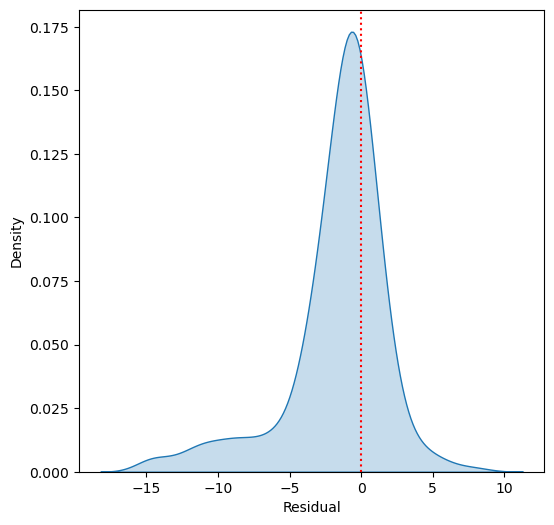

In [57]:
site_name = 'nyc21v6'
model_name = '2017_model_b'

kde_plot(site_name,model_name)

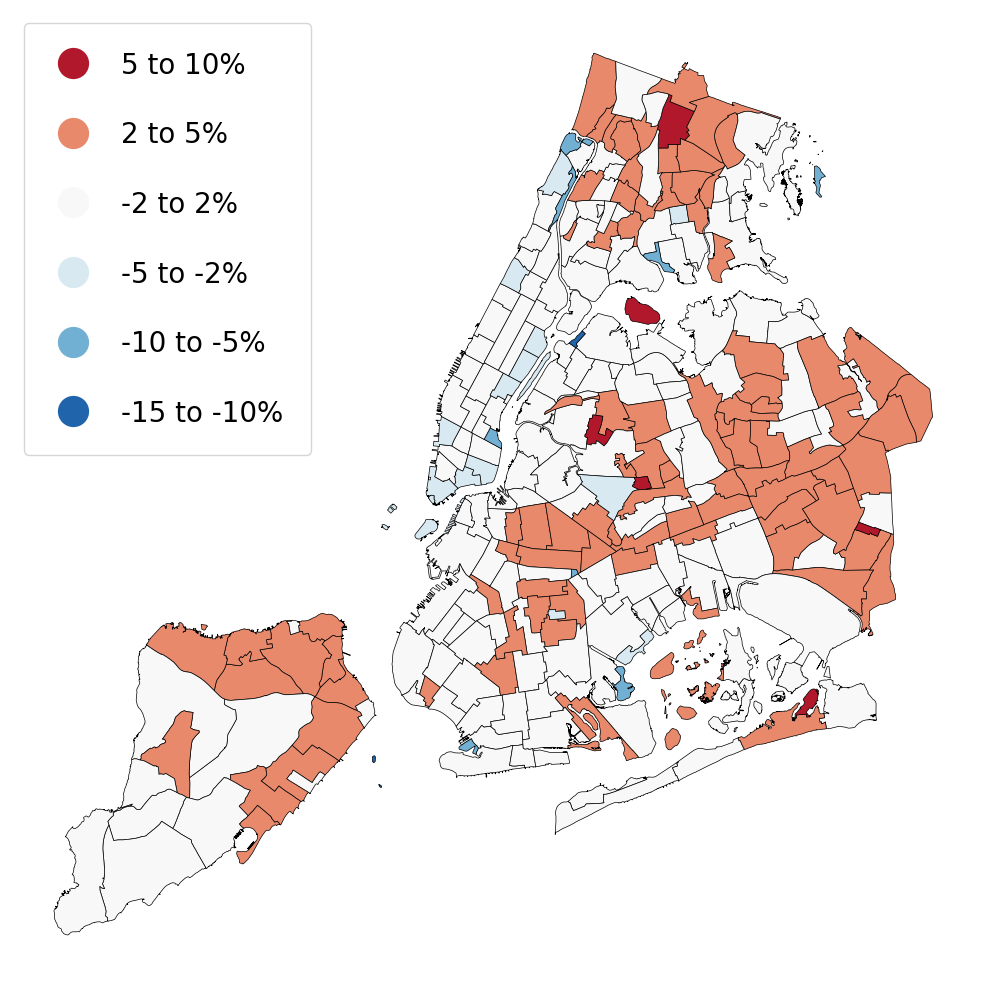

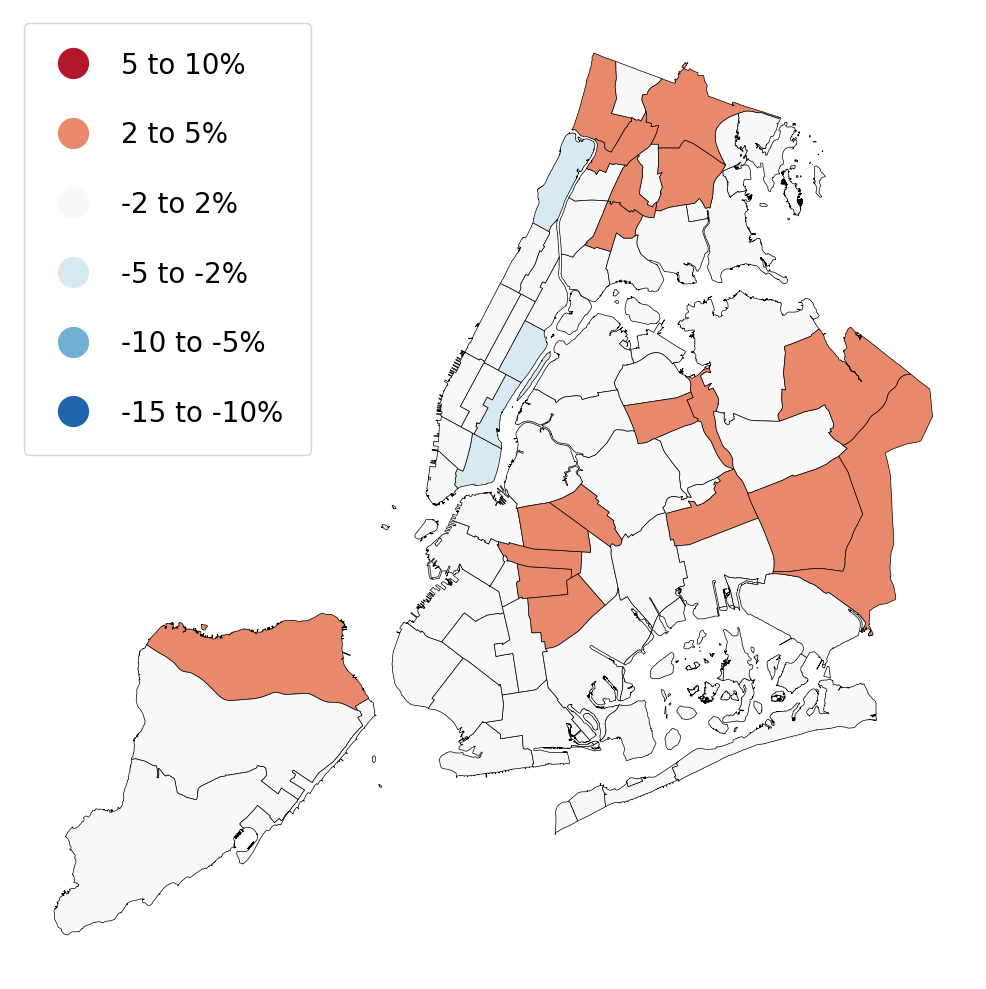

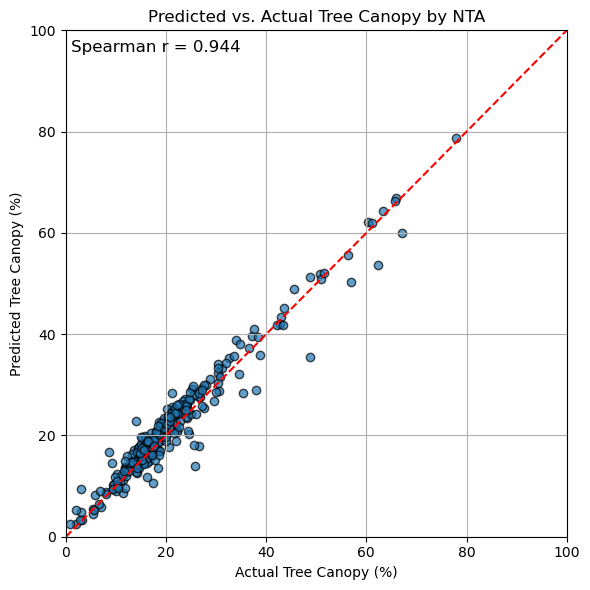

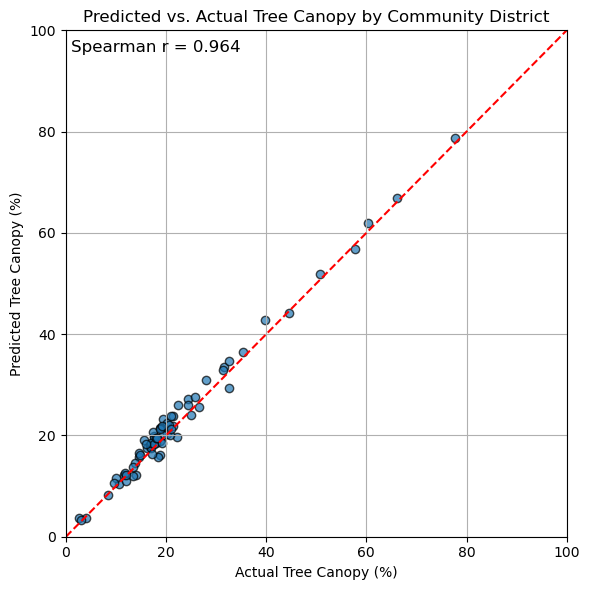

In [ ]:
plot_aggregated_residuals(site_name, model_name)
plot_actual_v_predicted_tc(site_name, model_name)

In [38]:
nta17 = gpd.read_file(root / 'output' / 'nyc17v6' / f'nta_for_nyc17v6_from_ensemble.gpkg')

In [45]:
cd17 = gpd.read_file(root / 'output' / 'nyc17v6' / f'community_district_for_nyc17v6_from_ensemble.gpkg')

In [8]:
nta21 = gpd.read_file(root / 'output' / 'nyc21v6' / f'nta_for_nyc21v6_from_ensemble.gpkg')

nta17 = gpd.read_file(root / 'output' / 'gpkg' / f'nta_for_nyc17v6_from_2017_model_b.gpkg')

nta17.columns

Index(['can_2017_pct', 'can_2021_pct', 'predicted_tree_canopy_percent_cover',
       'predicted_canopy_binned', 'difference', 'geometry'],
      dtype='object')

In [ ]:
plot_aggregated_change(model='2017_model_b',v='v1', ensemble=False,actual=False)

In [ ]:
plot_aggregated_tc(model='2021_model_b',site_name='nyc23',year='2023',v='v1',actual=False)

In [ ]:
def plot_aggregated_tc(model,site_name,year,v='v1',actual=False):

    nta = gpd.read_file(root / 'output' / 'gpkg' / f'nta_for_{site_name}_from_{model}.gpkg')
    cd = gpd.read_file(root / 'output' /  'gpkg' / f'commdist_for_{site_name}_from_{model}.gpkg')

    # define bins
    bins = [0, 20, 40, 60, 80, 100]
    labels = ['0 to 20%','20 to 40%','40 to 60%', '60 to 80%', '80 to 100%']

    colors = plt.cm.Greens(np.linspace(0.2, 0.9, len(labels)))
    cmap = mcolors.ListedColormap(colors)

    if actual:
        col = f'can_{year}_pct'
    else:
        col = 'predicted_tree_canopy_percent_cover'

    for bound, bound_name in zip([nta,cd],['nta','commdist']):

        bound[f'predicted_canopy_binned'] = pd.cut(bound[col], 
                            bins=bins, 
                            labels=labels, 
                            include_lowest=True)


        ax = bound.plot(column=f'predicted_canopy_binned',
        cmap=cmap,
        legend=True,
        legend_kwds={'loc': 'upper left', 'fontsize':20,'markerscale':1.5,'labelspacing':1.5,'handlelength':1.5, 'handletextpad':1.0,'borderpad':1},
        categorical=True,
        edgecolor='black',
        linewidth=0.5,
        figsize=(10, 10))


        plt.axis('off')
        plt.tight_layout()

        if actual:
            plt.savefig(f'{bound_name}_actual_for_{year}_{v}.png')
        else:
            plt.savefig(root / 'output' / site_name / f'{bound_name}_for_{site_name}_from_{model}_{v}.png')

In [30]:
def plot_aggregated_change(model,v,ensemble=False,actual=False):
    
    if ensemble:
        folder1 = 'nyc17v6'
        folder2 = 'nyc21v6'
        cd = 'community_district'
    else:
        folder1 = 'gpkg'
        folder2 = 'gpkg'
        cd = 'commdist'
    
    nta17 = gpd.read_file(root / 'output' / folder1 / f'nta_for_nyc17v6_from_{model}.gpkg')
    cd17 = gpd.read_file(root / 'output' /  folder1 / f'{cd}_for_nyc17v6_from_{model}.gpkg')

    nta21 = gpd.read_file(root / 'output' /  folder2 / f'nta_for_nyc21v6_from_{model}.gpkg')
    cd21 = gpd.read_file(root / 'output' /  folder2 / f'{cd}_for_nyc21v6_from_{model}.gpkg')

    nta17['actual_change'] = nta17['can_2021_pct'] - nta17['can_2017_pct']
    cd17['actual_change'] = cd17['can_2021_pct'] - cd17['can_2017_pct']

    if ensemble:
        nta17['predicted_change'] = nta21["predicted_can_2021_pct"] - nta17["predicted_can_2017_pct"]
        cd17['predicted_change'] = cd21["predicted_can_2021_pct"] - cd17["predicted_can_2017_pct"]
    else:
        nta17['predicted_change'] = nta21["predicted_tree_canopy_percent_cover"] - nta17["predicted_tree_canopy_percent_cover"]
        cd17['predicted_change'] = cd21["predicted_tree_canopy_percent_cover"] - cd17["predicted_tree_canopy_percent_cover"]

    bins = [-15, -10, -5,  0,  5, 10, 15]
    labels = ['-15% to -10%', '-10% to -5%', '-5% to 0%', '0% to 5%', '5% to 10%', '10% to 15%']

    # bins = [-10, -6, -2, 2, 6, 10]
    # labels = ['-10% to -6%', '-6% to -2%', '-2% to 2%', '2% to 6%', '6% to 10%']
    colors = plt.cm.PiYG(np.linspace(0.2, 0.9, len(labels)))
    cmap = mcolors.ListedColormap(colors)
        
    for bound, bound_name in zip([nta17, cd17], ['nta','community_district']):

       
        
        bound[f'predicted_change_binned'] = pd.cut(bound['predicted_change'], 
                            bins=bins, 
                            labels=labels, 
                            include_lowest=True)

        ax = bound.plot(column='predicted_change_binned',
        cmap=cmap,
        legend=True,
        categorical=True,
        edgecolor='black',
        linewidth=0.5,
        figsize=(10, 10))

        leg = ax.get_legend()
        if leg:
            handles = leg.legend_handles if hasattr(leg, 'legend_handles') else leg.get_lines()
            labels_leg = [t.get_text() for t in leg.texts]
            ax.legend(handles[::-1], labels_leg[::-1],loc='upper left', 
                fontsize=20,      
                markerscale=1.5,       
                labelspacing=1.5,      
                handlelength=1.5,      
                handletextpad=1.0,     
                borderpad=1)

        plt.title(f"Predicted Change {model}")
        plt.axis('off')
        plt.tight_layout()

     
        plt.savefig(root / 'output' / f'change_{bound_name}_from_{model}_{v}.png')

        if actual:
            bound[f'actual_change_binned'] = pd.cut(bound['actual_change'], 
                            bins=bins, 
                            labels=labels, 
                            include_lowest=True)

            ax = bound.plot(column='actual_change_binned',
            cmap=cmap,
            legend=True,
            categorical=True,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))

            leg = ax.get_legend()
            if leg:
                handles = leg.legend_handles if hasattr(leg, 'legend_handles') else leg.get_lines()
                labels_leg = [t.get_text() for t in leg.texts]
                ax.legend(handles[::-1], labels_leg[::-1],loc='upper left', 
                    fontsize=20,         
                    markerscale=1.5,       
                    labelspacing=1.5,      
                    handlelength=1.5,      
                    handletextpad=1.0,     
                    borderpad=1)

            plt.title(f"Actual Change")
            plt.axis('off')
            plt.tight_layout()

        
            plt.savefig(root / 'output' / f'actual_change_{bound_name}_{v}.png')



In [ ]:
class CanopyPredictions():
    def __init__(self,root,site_name,train_site_name,prediction_raster,lidar_raster,result_df,valid_mask,model_name,training_vars,test_set_rmse=None,formatted=False):
        self.root = root 
        self.model_name = model_name
        self.training_vars = training_vars
        self.site_name = site_name
        self.train_site_name = train_site_name
        self.prediction_raster = prediction_raster
        self.lidar_raster = lidar_raster
        self.x_coords = self.prediction_raster.x.values
        self.y_coords = self.prediction_raster.y.values
       
        self.pred_valid_mask = valid_mask   # for reshaping to raster dimensions
        self.test_set_rmse = test_set_rmse

        self.result_df = self.format_df(result_df) if not formatted else result_df

        self.scores= self.calculate_scores()

        if not os.path.exists(self.root / 'output' / self.site_name):
            os.makedirs(self.root / 'output' / self.site_name)
        
        save_path = self.root / 'output' / self.site_name / self.model_name
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        self.save_path = save_path

        # save to predictions tif to disk if file doesn't already exist
        if not (self.save_path / f'predictions_for_{self.site_name}_from_{self.model_name}.tif').is_file():
            to_disk = self.prediction_raster*100
            to_disk.rio.to_raster(save_path / f'predictions_for_{self.site_name}_from_{self.model_name}.tif')

        
        # nta_path = self.root / 'output' / self.site_name / f'nta_for_{self.site_name}_from_{self.model_name}.gpkg'
        # cd_path = self.root / 'output' / self.site_name / f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg'
        # if nta_path.is_file():
        #     self.nta_gdf = gpd.read_file(nta_path)
        # else:
        #     self.nta_gdf = None
        
        # if cd_path.is_file():
        #     self.cd_gdf = gpd.read_file(cd_path)
        # else:
        #     self.cd_gdf = None

        nta = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_nta2020')
        nta = nta.to_crs(self.prediction_raster.rio.crs)
        self.nta_actual = nta.loc[:,['can_2017_pct','can_2021_pct','geometry']] 
        
        cd = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_commboard2020')
        cd = cd.to_crs(self.prediction_raster.rio.crs)
        self.cd_actual = cd.loc[:,['can_2017_pct','can_2021_pct','geometry']]
            
    def format_df(self,input):
        
        df1 = input.copy()
        df1 = df1.rename(columns={'canopy':'actual_tc'})
        df1['actual_tc'] = df1['actual_tc']*100
        df1['predicted_tc'] = df1['predicted_tc']*100
        df1['residual'] = df1['predicted_tc'] - df1['actual_tc'] 
        
        return df1
    
    def make_geo_array(self,r,col_name):
        valid_mask = getattr(self,f'{r}_valid_mask')
        data = np.full(valid_mask.shape, np.nan)

        df = self.result_df
        
        data[valid_mask] = df[col_name]

        crs = self.prediction_raster.rio.crs

        geo_array = xr.DataArray(data,dims=('y','x'),coords={'y':self.y_coords,'x':self.x_coords})

        # add spatial info
        geo_array = geo_array.rio.write_crs(crs).rio.set_spatial_dims(
            x_dim="x",y_dim="y").rio.write_coordinate_system()
        
        return geo_array

    
    
    def to_npz(self):
            
        save_path = self.root / 'output' / self.site_name / f'results_for_{self.site_name}_from_{self.model_name}.npz'
        np.savez_compressed(
            save_path,
            root = self.root,
            site_name=self.site_name,
            train_site_name=self.train_site_name,
            test_set_rmse=self.test_set_rmse,
            model_name = self.model_name,
            training_vars = np.array(self.training_vars),
            pred_valid_mask=self.pred_valid_mask,
            prediction_raster=self.prediction_raster.values,
            lidar_raster = self.lidar_raster.values,
            x_coords = self.x_coords,
            y_coords = self.y_coords,
            epsg = self.prediction_raster.rio.crs.to_epsg(),
            result_df=self.result_df.values,
            result_df_columns=self.result_df.columns.to_numpy(),
            result_df_index=self.result_df.index.to_numpy()
        )

    @classmethod
    def from_npz(cls, path):

        with np.load(path,allow_pickle=True) as data:
            root = data["root"].item()
            site_name = data["site_name"].item()
            train_site_name = data["train_site_name"].item()
            test_set_rmse = data["test_set_rmse"].item()
            epsg = data['epsg'].item()
            model_name = data['model_name'].item()
            training_vars = data['training_vars']


            x_coords = data['x_coords']
            y_coords = data['y_coords']
            pred_valid_mask = data["pred_valid_mask"]
            

            result_df = pd.DataFrame(
                data["result_df"],
                columns=data["result_df_columns"],
                index=data["result_df_index"]
            )

            df_dtypes = {'actual_tc': 'float64',
            'predicted_tc': 'float64',
            'classifier_preds': 'int64',
            'residual': 'float64',
          }

            for col, dtype in df_dtypes.items():
                if col in result_df.columns:
                    result_df[col] = result_df[col].astype(dtype)


            raster_data = data["prediction_raster"]
            # convert to xarray with spatial info
            prediction_raster = xr.DataArray(raster_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            prediction_raster = prediction_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            
            lidar_data = data['lidar_raster']

            lidar_raster = xr.DataArray(lidar_data, dims=("y", "x"), coords={"y": y_coords, "x": x_coords})
            lidar_raster = lidar_raster.rio.write_crs(epsg).rio.set_spatial_dims(
                x_dim="x",y_dim="y").rio.write_coordinate_system()
            
            return cls(
                root = root,
                site_name=site_name,
                train_site_name=train_site_name,
                prediction_raster=prediction_raster,
                lidar_raster=lidar_raster,
                valid_mask=pred_valid_mask,
                result_df=result_df,
                test_set_rmse=test_set_rmse,
                model_name=model_name,
                training_vars=training_vars,
                formatted=True
            )
        
    def calculate_scores(self):
        
        actual_tc = self.result_df['actual_tc']
        actual_binary = (self.result_df['actual_tc'] > 0).astype(int)

        predicted_tc = self.result_df['predicted_tc']
        classifier_preds = self.result_df['classifier_preds']

        mae = mean_absolute_error(actual_tc,predicted_tc)
        rmse = root_mean_squared_error(actual_tc,predicted_tc)

        scores = {'mae':mae,'rmse':rmse}

        scores['model'] = self.model_name
        scores['vars'] = list(self.training_vars)
        scores['train_site'] = self.train_site_name
        scores['site_name'] = self.site_name
        scores['test_set_rmse'] = self.test_set_rmse
        scores['timestamp'] = datetime.now().isoformat()

        # Masks
        tp_mask = (classifier_preds == 1) & (actual_binary == 1)
        fp_mask = (classifier_preds == 1) & (actual_binary == 0)
        fn_mask = (classifier_preds == 0) & (actual_binary == 1)
        tn_mask = (classifier_preds == 0) & (actual_binary == 0)

        # Extract values
        tp_error = root_mean_squared_error(actual_tc[tp_mask], predicted_tc[tp_mask])
        fp_error = root_mean_squared_error(actual_tc[fp_mask], predicted_tc[fp_mask])
        fn_error = root_mean_squared_error(actual_tc[fn_mask], predicted_tc[fn_mask])
        tn_error = root_mean_squared_error(actual_tc[tn_mask], predicted_tc[tn_mask])

        scores['tp_rmse'] = tp_error
        scores['fp_rmse'] = fp_error
        scores['fn_rmse'] = fn_error
        scores['tn_rmse'] = tn_error

        precision_per_class = precision_score(actual_binary, classifier_preds, average=None, labels=[0, 1])
        recall_per_class = recall_score(actual_binary, classifier_preds, average=None, labels=[0, 1])

        # Assign for clarity
        precision_class_0, precision_class_1 = precision_per_class
        recall_class_0, recall_class_1 = recall_per_class

        scores['canopy_prec'] = precision_class_1*100
        scores['canopy_recall'] = recall_class_1*100
        scores['zerocanopy_prec'] = precision_class_0*100
        scores['zerocanopy_recall'] = recall_class_0*100

        # add 180m res results



        return scores
    
    def save_scores(self):
        
        save_path = self.root / 'output' / f'scores.json'

        if save_path.exists():
            with open(save_path,'r') as f:
                scores_file = json.load(f)
        else:
            print('initializing new scores log')
            scores_file = []

        scores_file.append(self.scores)

        with open(save_path,'w') as f:
            json.dump(scores_file,f,indent=2)
        
        print(f'scores save to {save_path}')

    def print_model_info(self):
        print(print(f"""Site Name: {self.site_name}
                        Train Site: {self.train_site_name}
                        Model: {self.model_name}
                        Overall:
                        \tMAE: {self.scores['mae']:.2f}
                        \tRMSE: {self.scores['rmse']:.2f}
                        \tTest set RMSE: {self.test_set_rmse}
                        Classifier Metrics:
                        \t% correct zero canopy labels: {self.scores['zerocanopy_prec']:.2f}
                        \t% zero canopy pixels found: {self.scores['zerocanopy_recall']:.2f}
                        RMSE by classification: 
                        \tTP RMSE (correctly predicted canopy): {self.scores['tp_rmse']:.2f}
                        \tTN RMSE (correctly predicted no canopy):   {self.scores['tn_rmse']:.2f}
                        \tFP RMSE (predicted canopy, actually none): {self.scores['fp_rmse']:.2f}
                        \tFN RMSE (missed actual canopy):            {self.scores['fn_rmse']:.2f}
                    """
                    ))
        
        

    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        if cmap == 'Greens':
            vmin = 0
            vmax = 100
        else:
            vmin = -50
            vmax = 50
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str


    
    
    def aggregate_tc(self,canopy_raster,res_list):

        res_dict = {}

        pixel_area = 900 # 900 m-2 per pixel

        for res in res_list:
            factor = int(round(res / 30))  # aggregation factor

            valid_mask = canopy_raster.notnull().astype(float)  # 1 for valid, 0 for NaN
            tc_in_meters = (canopy_raster/100) * pixel_area

            # get canopy area in meters per window
            total_canopy_in_window = tc_in_meters.coarsen(x=factor, y=factor, boundary='trim').sum()
            total_valid_area_in_window = (valid_mask * pixel_area).coarsen(x=factor, y=factor, boundary='trim').sum()

            canopy_pct = (total_canopy_in_window / total_valid_area_in_window)*100

            res_dict[f'{res}m res'] = canopy_pct
        
        return res_dict


    def calc_scores(self,res,pred_res_dict,actual_res_dict):

        t = xr.concat([pred_res_dict[f'{res}m res'].expand_dims({'band':['pred']}),actual_res_dict[f'{res}m res'].expand_dims({'band':['actual']})],dim='band')

        df = rearrange(t.values,'b h w -> (h w) b')
        col_names = t.band.values
        d = pd.DataFrame(df,columns=col_names)
        d = d.dropna(axis=0)
        d['actual_binary'] = (d['actual'] > 0).astype(int)
        d['pred_binary'] = (d['pred'] > 0).astype(int)

        scores = {}

        scores['rmse'] = np.round(root_mean_squared_error(d['actual'],d['pred']),2)
        scores['mae'] = np.round(mean_absolute_error(d['actual'],d['pred']),2)


        scores['prec_0'] = precision_score(d['actual_binary'], d['pred_binary'], average=None, labels=[0])[0]*100
        scores['recall_0']= recall_score(d['actual_binary'], d['pred_binary'], average=None, labels=[0])[0]*100

        return scores
    
    def calculate_aggregated_scores(self,res_list=[30,60,90,120,150,180,200]):

        pred_tc = self.make_geo_array('pred','predicted_tc')
        actual_tc = self.make_geo_array('pred','actual_tc')

        pred_res_dict = self.aggregate_tc(pred_tc,res_list[1:])
        actual_res_dict = self.aggregate_tc(actual_tc,res_list[1:])

        if 180 in res_list:
            self.agg_preds = pred_res_dict['180m res']
            self.agg_actual = actual_res_dict['180m res']

        rmse_list = [self.scores['rmse']]
        mae_list = [self.scores['mae']]
        prec_list = [self.scores['zerocanopy_prec']]
        recall_list = [self.scores['zerocanopy_recall']]

        for res in res_list[1:]:
            scores_dict= self.calc_scores(res,pred_res_dict,actual_res_dict)
            rmse_list.append(scores_dict['rmse'])
            mae_list.append(scores_dict['mae'])
            prec_list.append(scores_dict['prec_0'])
            recall_list.append(scores_dict['recall_0'])


        scores_df = pd.DataFrame({'res':res_list,'rmse':rmse_list,'mae':mae_list,'precision':prec_list,'recall':recall_list})

        self.agg_scores = scores_df
        scores_df.to_csv(self.save_path / f'aggregated_scores_for_{self.site_name}_from_{self.model_name}.csv')

    
    
        
    def map_predictions(self,save=False):

        
        pred_tc = self.prediction_raster.rio.reproject('EPSG:4326')
        pred_tc = pred_tc*100
        actual_tc = self.lidar_raster.rio.reproject('EPSG:4326')
        actual_tc = actual_tc*100
        residual = self.make_geo_array('pred','residual').rio.reproject('EPSG:4326')

        agg_pred_tc = self.agg_preds.rio.reproject('EPSG:4326')
        agg_actual_tc = self.agg_actual.rio.reproject('EPSG:4326')
        agg_residual = agg_pred_tc - agg_actual_tc
       

        # find coordinates for map center
        lats = pred_tc.y.values
        lons = pred_tc.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

      

        pred_img_str, pred_cb, bounds = self.create_image_overlay(pred_tc, lats, lons,cmap='Greens',bounds=True)
        actual_img_str, actual_cb = self.create_image_overlay(actual_tc, lats, lons,cmap='Greens')
        residual_img_str, resid_cb  = self.create_image_overlay(residual, lats, lons,cmap='RdBu_r')

        agg_pred_img_str, agg_pred_cb = self.create_image_overlay(agg_pred_tc, lats, lons,cmap='Greens')
        agg_actual_img_str, agg_actual_cb = self.create_image_overlay(agg_actual_tc, lats, lons,cmap='Greens')
        agg_residual_img_str, agg_resid_cb  = self.create_image_overlay(agg_residual, lats, lons,cmap='RdBu_r')
      


        # overlay in-memory image on folium map 
        layers = [
            ('Predicted Tree Canopy 30m', pred_img_str),
            ('Actual Tree Canopy 30m', actual_img_str),
            ('Residuals 30m', residual_img_str),
            ('Predicted Tree Canopy 180m', agg_pred_img_str),
            ('Actual Tree Canopy 180m', agg_actual_img_str),
            ('Residuals 180m', agg_residual_img_str)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Tree Canopy" class="colorbar">
            <img src="data:image/png;base64,{{this.pred_cb_img}}">
        </div>
        <div id="legend-Residuals" class="colorbar">
            <img src="data:image/png;base64,{{this.resid_cb_img}}">
        </div>

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.pred_cb_img = pred_cb
        cb_macro.resid_cb_img = resid_cb
        cb_macro.actual_cb_img = actual_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            m.save(self.save_path / f'canopy_predictions_for_{self.site_name}_from_{self.model_name}.html')
       

        return m
    

    def aggregate_to_boundaries(self, save=False):
      

        pred_tree_canopy = self.prediction_raster
    
        nta_gdf = self.nta_actual.copy()
        cd_gdf = self.cd_actual.copy()
        #### aggregate to boundaries
        #for tree_canopy, tc_name in zip([actual_tree_canopy, pred_tree_canopy], ['actual', 'predicted']):

        for bound, bound_name in zip([nta_gdf, cd_gdf], ['nta', 'community_district']):

            canopy_percent_list = []

            for _, row in bound.iterrows():
                geom = [mapping(row.geometry)]

                # Create a mask for pixels inside the polygon
                mask = geometry_mask(geom,
                                    transform=pred_tree_canopy.rio.transform(),
                                    invert=True,
                                    out_shape=(pred_tree_canopy.shape[-2], pred_tree_canopy.shape[-1]))

                # Extract canopy values within the polygon
                canopy_vals = np.where(mask, pred_tree_canopy.values, np.nan)

                # Calculate area covered by canopy (as percent * pixel area)
                canopy_area_m2 = np.nansum(canopy_vals * 900)

                # Total area of polygon in m²
                polygon_area_m2 = row.geometry.area

                # Percent of polygon covered by canopy
                percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

                canopy_percent_list.append(percent_cover)


            bound[f"predicted_tree_canopy_percent_cover"] = canopy_percent_list

            # define bins
            bins = [0, 20, 40, 60, 80, 100]
            labels = ['0 to 20%','20 to 40%','40 to 60%', '60 to 80%', '80 to 100%']

            colors = plt.cm.Greens(np.linspace(0.2, 0.9, len(labels)))
            cmap = mcolors.ListedColormap(colors)

            bound[f'predicted_canopy_binned'] = pd.cut(bound[f'predicted_tree_canopy_percent_cover'], 
                                bins=bins, 
                                labels=labels, 
                                include_lowest=True)

            
            ax = bound.plot(column=f'predicted_canopy_binned',
            cmap=cmap,
            legend=True,
            legend_kwds={'loc': 'upper left', 'fontsize':20,'markerscale':1.5,'labelspacing':1.5,'handlelength':1.5, 'handletextpad':1.0,'borderpad':1},
            categorical=True,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))

            
            plt.axis('off')
            plt.tight_layout()

            if save:
                plt.savefig(f'{bound_name}_for_{self.site_name}_from_{self.model_name}.png')

        if '17' in self.site_name:
            year = '2017'
        elif '21' in self.site_name:
            year = '2021'

        nta_gdf['difference'] = nta_gdf['predicted_tree_canopy_percent_cover'] - nta_gdf[f'can_{year}_pct']
        cd_gdf['difference'] = cd_gdf['predicted_tree_canopy_percent_cover'] - cd_gdf[f'can_{year}_pct']

        self.nta_preds = nta_gdf
        self.cd_preds = cd_gdf

        self.nta_preds.to_file(self.save_path /  f'nta_for_{self.site_name}_from_{self.model_name}.gpkg')
        self.cd_preds.to_file(self.save_path /  f'commdist_for_{self.site_name}_from_{self.model_name}.gpkg')

        plt.figure(figsize=(6, 6))
        sns.kdeplot(data=self.nta_preds, x='difference',fill='blue')
        plt.axvline(x=0, ls=':', color='red')
        plt.xlabel('Residual')
        plt.ylabel('Density')
        if save:
            plt.savefig(f'nta_kde_for_{self.site_name}_from_{self.model_name}.png')


        for bound, bound_name in zip([nta_gdf, cd_gdf], ['neighborhood tabulation area','community district']):
            
            m_val = bound['difference'].min()
            
            # define bins
            if m_val < -15:
                bins = [m_val, -10, -5, -2, 2, 5, 10, 15]
                labels = ['< -10%','-10 to -5%', '-5 to -2%', '-2 to 2%', '2 to 5%', '5 to 10%', '> 10%']
            else:
                bins = [-15, -10, -5, -2, 2, 5, 10, 15]
                labels = ['-15 to -10%','-10 to -5%', '-5 to -2%', '-2 to 2%', '2 to 5%', '5 to 10%', '10 to 15%']
            # Distribute colors symmetrically
            n_colors = len(labels)
            colors = plt.cm.RdBu_r(np.linspace(0.1, 0.9, n_colors)) 

            center = labels.index('-2 to 2%')
            colors[center] = list(mcolors.to_rgba('#F8F8F8'))

            cmap = mcolors.ListedColormap(colors)

            bound[f'difference_binned'] = pd.cut(bound['difference'], 
                                bins=bins, 
                                labels=labels, 
                                include_lowest=True)
            
            ax = bound.plot(column=f'difference_binned',
                    cmap=cmap,
                    legend=True,
                    #legend_kwds={'loc': 'upper left', 'fontsize': 'xx-large','markerscale': 1.5},
                    # legend_kwds={'prop':{'size':'xx-large'}},
                    legend_kwds={'loc': 'upper left', 'fontsize':30,'markerscale':1.5,'labelspacing':3,'handlelength':3, 'handletextpad':3,'borderpad':4},
                    categorical=True,
                    edgecolor='black',
                    linewidth=0.5,
                    figsize=(10, 10))
            
            # flip order of legend (put positive values on top)
            leg = ax.get_legend()
            if leg:
                handles = leg.legend_handles if hasattr(leg, 'legend_handles') else leg.get_lines()
                labels_leg = [t.get_text() for t in leg.texts]
                ax.legend(handles[::-1], labels_leg[::-1], 
                 loc='upper left', 
                 fontsize=20,
                 markerscale=1.5,       
                 labelspacing=1.5,      
                 handlelength=1.5,      
                 handletextpad=1.0,     
                 borderpad=1)

            
            plt.axis('off')
            plt.tight_layout()

            
            plt.savefig(f'residuals_{bound_name}_for_{self.site_name}_from_{self.model_name}.png')


  
    def plot_aggregated_actual_vs_predicted_tc(self,save=False):

        if not hasattr(self, 'nta_preds') or self.nta_preds is None:
            print('run .aggregate_to_boundaries() first')
        else:

            for bound in ['nta','cd']:

                gdf = getattr(self,f'{bound}_preds')

                title = 'NTA' if bound == 'nta' else 'Community District'

                if '17' in self.site_name:
                    year = '2017'
                elif '21' in self.site_name:
                    year = '2021'

                x = gdf[f'can_{year}_pct']
                y = gdf['predicted_tree_canopy_percent_cover']

                spearman_r, _ = spearmanr(x, y)
                #rsquared = r2_score(x,y)

                plt.figure(figsize=(6, 6))
                plt.scatter(x, y, alpha=0.7, edgecolor='k')
                plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # AB line

                plt.text(0.01, 0.98, f"R$^2$ = {spearman_r:.3f}", 
                transform=plt.gca().transAxes, 
                fontsize=12, 
                verticalalignment='top')

                plt.xlabel('Actual Tree Canopy (%)')
                plt.ylabel('Predicted Tree Canopy (%)')
                plt.title(f'Predicted vs. Actual Tree Canopy by {title}')
                plt.xlim(0, 100)
                plt.ylim(0, 100)
                plt.grid(True)
                plt.tight_layout()
                if save:
                    plt.savefig(self.save_path / f'actualvspredicted_{bound}_for_{self.site_name}_from_{self.model_name}.png')

In [3]:
cp = CanopyPredictions.from_npz(root / 'output' / 'nyc17v6' / 'results_for_nyc17v6_from_2017_model_b.npz')

#cp.calculate_aggregated_scores(res_list=[30,180])
# cp.map_predictions(save=True)
#cp.aggregate_to_boundaries(save=True)
# cp.plot_aggregated_actual_vs_predicted_tc(save=True)

In [ ]:
# fit linear regression to pixels tc = m*year + b
preds23 = pred23.expand_dims({'time':[2023]})
preds17 = cp.agg_preds.expand_dims({'time':[2017]})
preds21 = cp.agg_preds.expand_dims({'time':[2021]})

t = xr.concat([preds17,preds21,preds23],dim='time')
pf = t.polyfit(dim='time', deg=1, skipna=True)
slope = pf['polyfit_coefficients'].sel(degree=1)

In [ ]:
cp = CanopyPredictions.from_npz(root / 'output' / 'nyc21v6' / 'results_for_nyc21v6_from_2017_model_b.npz')

cp.calculate_aggregated_scores()
cp.map_predictions(save=True)
cp.aggregate_to_boundaries(save=True)
cp.plot_aggregated_actual_vs_predicted_tc(save=True)

In [83]:
ca = ChangeAnalysis(root, 'nyc17v6', 'nyc21v6', '2021_model')

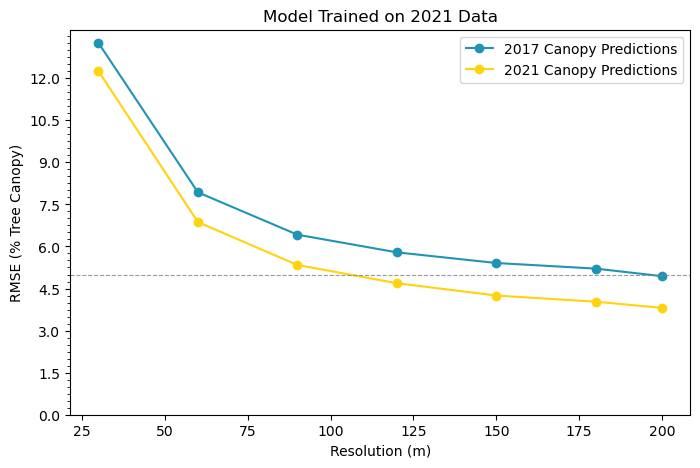

In [27]:
def plot_rmse_vs_scale(model_name,site17='nyc17v6',site21='nyc21v6',change=False,nlcd=False):
        
        if change:
                r_17 = pd.read_csv(root/'output' / f'change_aggregated_scores_from_2017_model_b.csv' )
                r_21 = pd.read_csv(root/'output' / f'change_aggregated_scores_from_2021_model_b.csv' )
                r_nlcd = pd.read_csv(root / 'output' /  f'change_aggregated_scores_nlcd.csv')

                label17 = '2017 Model'
                color17 = "#b41f8f"
                label21 = '2021 Model'
                color21 = "#269a35"
                title = 'RMSE: Change in Tree Canopy'
                ylab = 'RMSE (Change in % Tree Canopy)'

                if nlcd:
                        labelnlcd = 'NLCD'
                        colornlcd = "#26349a"

        else:
                r_17 = pd.read_csv(root/'output' / site17 / f'aggregated_scores_for_{site17}_from_{model_name}.csv' )
                r_21 = pd.read_csv(root/'output' / site21 / f'aggregated_scores_for_{site21}_from_{model_name}.csv' )

                label17 = '2017 Canopy Predictions'
                color17 = '#1f94b4'
                label21 = '2021 Canopy Predictions'
                color21 = '#ffd30e'
                title = f'Model Trained on {model_name.split('_')[0]} Data'
                ylab = 'RMSE (% Tree Canopy)'

       
        plt.figure(figsize=(8,5))

        plt.plot(r_17['res'],r_17['rmse'],marker='o',label=label17,color=color17)
        plt.plot(r_21['res'],r_21['rmse'],marker='o', label=label21, color=color21) 
        if nlcd:
                plt.plot(r_nlcd['res'],r_nlcd['rmse'],marker='o', label=labelnlcd, color=colornlcd)

        plt.xlabel('Resolution (m)')
        plt.ylabel(ylab)
        plt.yticks(np.arange(0,np.max(np.concatenate([r_17['rmse'],r_21['rmse']])),1.5))
        plt.title(title)
        plt.legend()
        plt.axhline(y=5,alpha=0.8,linewidth=.8,color='grey',linestyle='--')
        #plt.grid(True)
        ax = plt.gca()
        ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))  # finer vertical grid
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(50)) 
        #ax.grid(which='minor', linestyle=':', linewidth=0.5)  
        #ax.grid(which='major', linestyle='-', linewidth=0.8)
        #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x}%'))

        # if save:
        #     plt.savefig(self.root / 'output' / f'rmse_vs_scale_for_{self.site_name}_from_{self.model_name}.png')
        
        plt.show()

plot_rmse_vs_scale(model_name='2021_model_b',change=False,nlcd=False)

In [52]:
ca = ChangeAnalysis(root,'nyc17v6','nyc21v6','2017_model_b')

In [ ]:
ca.calculate_aggregated_scores()
ca.plot_change_boundaries(save=True)
ca.kde_plot()
ca.map_change(save=True)

In [ ]:

class ChangeAnalysis():
    def __init__(self, root, site17, site21, model_name):
        self.root = root
        self.model_name = model_name
        actual_change = xr.open_dataarray(root / 'output' / 'tif' / 'actual_diff_2017_2021.tif')
        self.actual_change = actual_change.isel(band=0)

        preds_2017 = CanopyPredictions.from_npz(root / 'output' / site17 / f'results_for_{site17}_from_{model_name}.npz' )
        self.preds_2017 = preds_2017.prediction_raster*100

        preds_2021 = CanopyPredictions.from_npz(root / 'output' / site21 / f'results_for_{site21}_from_{model_name}.npz' )
        self.preds_2021 = preds_2021.prediction_raster*100

        self.pred_change = self.preds_2021 - self.preds_2017

        self.scores = self.calculate_scores()

        nlcd_17 = xr.open_dataarray(root / 'data' / 'nyc17' / 'nyc17_nlcd_tc.tif')
        #nlcd_17 = nlcd_17.isel(band=0)
        nlcd_21 = xr.open_dataarray(root / 'data' / 'nyc21' / 'nyc21_nlcd_tc.tif')
        #nlcd_21 = nlcd_21.isel(band=0)
        nlcd_change = nlcd_21 - nlcd_17
        self.nlcd_change = nlcd_change.rio.reproject_match(self.pred_change,resampling=Resampling.bilinear)

        ## actual nta/cd canopy cover
        nta = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_nta2020')
        nta = nta.to_crs(self.preds_2017.rio.crs)
        self.nta_actual = nta.loc[:,['can_netchng_pct_20172021','geometry']] 
        
        cd = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_commboard2020')
        cd = cd.to_crs(self.preds_2017.rio.crs)
        self.cd_actual = cd.loc[:,['can_netchng_pct_20172021','geometry']]

        ## predicted nta/ cd canopy cover
        nta_preds_2017 = gpd.read_file(root / 'output' /  'gpkg' / f'nta_for_{site17}_from_{model_name}.gpkg')
        cd_preds_2017 = gpd.read_file(root / 'output' /  'gpkg' / f'commdist_for_{site17}_from_{model_name}.gpkg')

        nta_preds_2021 = gpd.read_file(root / 'output' / 'gpkg' / f'nta_for_{site21}_from_{model_name}.gpkg')
        cd_preds_2021 = gpd.read_file(root / 'output' /  'gpkg' / f'commdist_for_{site21}_from_{model_name}.gpkg')


        nta_pred_change = nta_preds_2021['predicted_tree_canopy_percent_cover'] - nta_preds_2017['predicted_tree_canopy_percent_cover']
        self.nta_change_gdf = gpd.GeoDataFrame(data={'predicted_change':nta_pred_change},geometry=nta_preds_2017.geometry,crs=nta_preds_2017.crs)

        cd_pred_change = cd_preds_2021['predicted_tree_canopy_percent_cover'] - cd_preds_2017['predicted_tree_canopy_percent_cover']
        self.cd_change_gdf = gpd.GeoDataFrame(data={'predicted_change':cd_pred_change},geometry=cd_preds_2017.geometry,crs=cd_preds_2017.crs)

        # nta_gdf['change_resid'] = nta_gdf['predicted_change'] - nta_gdf['can_netchng_pct_20172021']
        # cd_gdf['change_resid'] = cd_gdf['predicted_change'] - cd_gdf['can_netchng_pct_20172021']

    def kde_plot(self):

        nta_change_gdf = self.nta_change_gdf.copy()
        nta_change_gdf['difference'] = nta_change_gdf['predicted_change'] - self.nta_actual['can_netchng_pct_20172021']

        plt.figure(figsize=(6, 6))
        sns.kdeplot(data=nta_change_gdf, x='difference',fill='blue')
        plt.axvline(x=0,ls=':',color='red')
        plt.xlabel('Residual')
        plt.ylabel('Density')

        plt.savefig(root / 'output' / f'change_nta_kde_from_{self.model_name}.png')

    def plot_change_boundaries(self, save=False):
              
        # define bins
        all_values = []
        for boundary in ['nta', 'cd']:
            bound = getattr(self,f'{boundary}_change_gdf')
            all_values.extend(bound['predicted_change'].tolist())

        global_min = min(all_values)
        global_max = max(all_values)

        # Create bins and colors
        bins = [global_min-0.01, -5, -3, -1, 0, 1, 3, 5, global_max+0.01]
        labels = [f'<-5%', '-3 to -5%', '-1 to -3%', '0 to -1%', '0 to 1%', '1 to 3%', '3 to 5%', f'>5%']
        colors = plt.cm.PiYG(np.linspace(0.2, 0.9, len(labels)))
        cmap = mcolors.ListedColormap(colors)
        
        for boundary in ['nta', 'cd']:
            bound = getattr(self,f'{boundary}_change_gdf')

            bound[f'predicted_change_binned'] = pd.cut(bound['predicted_change'], 
                                bins=bins, 
                                labels=labels, 
                                include_lowest=True)

            
            ax = bound.plot(column='predicted_change_binned',
            cmap=cmap,
            legend=True,
            categorical=True,
            edgecolor='black',
            linewidth=0.5,
            figsize=(10, 10))

            leg = ax.get_legend()
            if leg:
                handles = leg.legend_handles if hasattr(leg, 'legend_handles') else leg.get_lines()
                labels_leg = [t.get_text() for t in leg.texts]
                ax.legend(handles[::-1], labels_leg[::-1],loc='upper left', 
                 fontsize=14,           
                 markerscale=1.5,       
                 labelspacing=1.5,      
                 handlelength=1.5,      
                 handletextpad=1.0,     
                 borderpad=1)

            plt.title(f"Predicted Change {self.model_name}")
            plt.axis('off')
            plt.tight_layout()

            if save:
                plt.savefig(self.root / 'output' / f'change_{boundary}_from_{self.model_name}.png')

        return bins, colors, labels, cmap

      
    def plot_aggregated_actual_vs_predicted_tc(self,save=False):

      
        for bound in ['nta', 'cd']:
            
            actual_gdf = getattr(self,f'{bound}_actual')
            pred_gdf = getattr(self,f'{bound}_change_gdf')

            title = 'NTA' if bound == 'nta' else 'Community District'


            x = actual_gdf['can_netchng_pct_20172021']
            y = pred_gdf['predicted_change']

            rsquared = r2_score(x, y)

            plt.figure(figsize=(6, 6))
            plt.scatter(x, y, alpha=0.7, edgecolor='k')
            plt.plot([-10, 20], [-10, 20], color='red', linestyle='--')  # AB line

            plt.text(0.01, 0.98, f"R$^2$ = {rsquared:.3f}", 
            transform=plt.gca().transAxes, 
            fontsize=12, 
            verticalalignment='top')

            plt.xlabel('Actual Change in % Tree Canopy')
            plt.ylabel('Predicted Change in % Tree Canopy')
            plt.title(f'Predicted vs. Actual Change in  % Tree Canopy by {title}')
            plt.xlim(-10, 20)
            plt.ylim(-10, 20)
            plt.grid(True)
            plt.tight_layout()
            if save:
                plt.savefig(self.root / 'output' / f'change_actualvspredicted_{bound}_from_{self.model_name}.png')

    def plot_rmse_vs_scale(self,save=False):
            rmse_df = self.agg_scores
            plt.figure(figsize=(8,5))

            plt.plot(rmse_df['res'],rmse_df['rmse'],marker='o')

            plt.xlabel('Resolution (m)')
            plt.ylabel('RMSE (Change in % Tree Canopy)')
            plt.yticks(np.arange(0,np.max(rmse_df['rmse']),1.5))
            plt.title(f'RMSE vs Aggregated Scale')
            #plt.grid(True)
            ax = plt.gca()
            ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))  # finer vertical grid
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(50)) 
            ax.grid(which='minor', linestyle=':', linewidth=0.5)  
            ax.grid(which='major', linestyle='-', linewidth=0.8)
            #plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x}%'))

            if save:
                plt.savefig(self.root / 'output' / f'change_rmse_vs_scale_from_{self.model_name}.png')
            
            plt.show()

    


    def calc_scores(self,res,pred_res_dict,actual_res_dict):

        if 'band' not in pred_res_dict[f'{res}m res'].dims:
            t = xr.concat([pred_res_dict[f'{res}m res'].expand_dims({'band':['pred']}),actual_res_dict[f'{res}m res'].expand_dims({'band':['actual']})],dim='band')
        else:
            pred_res_dict[f'{res}m res'] = pred_res_dict[f'{res}m res'].assign_coords({'band':['pred']})
            t = xr.concat([pred_res_dict[f'{res}m res'],actual_res_dict[f'{res}m res'].expand_dims({'band':['actual']})],dim='band')
        
        

        df = rearrange(t.values,'b h w -> (h w) b')
        col_names = t.band.values
        d = pd.DataFrame(df,columns=col_names)
        
        d = d.dropna(axis=0)
        
        

        scores = {}

        scores['rmse'] = np.round(root_mean_squared_error(d['actual'],d['pred']),2)
        scores['mae'] = np.round(mean_absolute_error(d['actual'],d['pred']),2)


        return scores

   

    

    def aggregate_tc_change(self, change_raster, res_list):
        res_dict = {}
        
        for res in res_list:
            factor = int(round(res / 30))
            
            # Simple mean of change values - this gives average change intensity
            avg_change = change_raster.coarsen(x=factor, y=factor, boundary='trim').mean()
            res_dict[f'{res}m res'] = avg_change
        
        return res_dict



    def calculate_aggregated_scores(self,res_list=[30,60,90,120,150,180,200],nlcd=False):

        if nlcd:
            pred_res_dict = self.aggregate_tc_change(self.nlcd_change,res_list)
            actual_res_dict = self.aggregate_tc_change(self.actual_change,res_list)
        else:
            pred_res_dict = self.aggregate_tc_change(self.pred_change,res_list[1:])
            actual_res_dict = self.aggregate_tc_change(self.actual_change,res_list[1:])

        if 180 in res_list:
            self.agg_preds = pred_res_dict['180m res']
            self.agg_actual = actual_res_dict['180m res']

        if nlcd:
            rmse_list = []
            mae_list = []
            loop = res_list
        else:
            rmse_list = [self.scores['rmse']]
            mae_list = [self.scores['mae']]
            loop = res_list[1:]


        for res in loop:
            scores_dict= self.calc_scores(res,pred_res_dict,actual_res_dict)
            rmse_list.append(scores_dict['rmse'])
            mae_list.append(scores_dict['mae'])
            
        scores_df = pd.DataFrame({'res':res_list,'rmse':rmse_list,'mae':mae_list})

        if nlcd:
            scores_df.to_csv(self.root / 'output' /  f'change_aggregated_scores_nlcd.csv')
        else:
            self.agg_scores = scores_df
            scores_df.to_csv(self.root / 'output' /  f'change_aggregated_scores_from_{self.model_name}.csv')


    def calculate_scores(self):

        df = pd.DataFrame({'actual': self.actual_change.values.ravel(), 'pred':self.pred_change.values.ravel()}).dropna()

        mae = np.round(mean_absolute_error(df['actual'],df['pred']),2)
        rmse = np.round(root_mean_squared_error(df['actual'],df['pred']),2)

        return {'mae':mae,'rmse':rmse}
    

    def create_image_overlay(self,data,lats, lons,cmap,bounds=False):

        min_lat, max_lat = float(lats.min()), float(lats.max())
        min_lon, max_lon = float(lons.min()), float(lons.max())
        extent = (min_lon, max_lon, min_lat, max_lat)

        vmin = -50
        vmax = 50
        
        # Create a temporary image
        height, width = data.shape
        fig, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
        img = ax.imshow(data, cmap=cmap, origin='upper',interpolation='none',extent=extent,vmin=vmin,vmax=vmax)
        plt.axis('off')

        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Save to a PNG buffer (in-memory)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', pad_inches=0,transparent=True)
        buf.seek(0)
        
        # encode as base64 for use in HTML image
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)

        # make colorbar image string
        fig_cb, ax_cb = plt.subplots(figsize=(4, 0.4))  
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cb = fig_cb.colorbar(sm, cax=ax_cb, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        fig_cb.subplots_adjust(bottom=0.5, top=0.9, left=0.1, right=0.9)

        buf_cb = io.BytesIO()
        plt.savefig(buf_cb, format='png', dpi=100, transparent=True)
        buf_cb.seek(0)
        cb_img_str = base64.b64encode(buf_cb.read()).decode('utf-8')
        plt.close(fig_cb)
        
        if bounds:
        # Get bounds for overlay
            min_lat, max_lat = lats.min(), lats.max()
            min_lon, max_lon = lons.min(), lons.max()
            bound = [[min_lat, min_lon], [max_lat, max_lon]]
            
            #plt.close(fig)
            
            return img_str, cb_img_str, bound
        else:
            #plt.close(fig)
            
            return img_str, cb_img_str
        

    def map_change(self,save=False):
        
        ## make xarrays for all desired layers
        change = self.pred_change.rio.reproject('EPSG:4326')
        actual = self.actual_change.rio.reproject('EPSG:4326')
        #residual = change - actual

        
    
        agg_pred_tc = self.agg_preds.rio.reproject('EPSG:4326')
        agg_actual_tc = self.agg_actual.rio.reproject('EPSG:4326')
        #agg_residual = agg_pred_tc - agg_actual_tc
       
        # find coordinates for map center
        lats = change.y.values
        lons = change.x.values
        center_lat = np.mean(lats)
        center_lon = np.mean(lons)
        map_center = [center_lat, center_lon]

        # Create the base map
        m = folium.Map(location=map_center, 
                        zoom_start=11,
                        tiles='Cartodb Positron',
                        attr='<a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> '
                            'contributors, <a href="https://cartodb.com/attributions">CartoDB</a>')

        # create color map
        #colormap = cm.linear.viridis.scale(vmin=0, vmax=100)
      
        img_str_change, cb_change, bounds = self.create_image_overlay(data=change, lats=lats, lons=lons,cmap='PiYG',bounds=True)
        img_str_actual, cb_actual = self.create_image_overlay(data=actual,lats=lats,lons=lons,cmap='PiYG',bounds=False)
        #residual_img_str, resid_cb  = self.create_image_overlay(residual, lats, lons,cmap='RdBu_r')
        
        agg_pred_img_str, agg_pred_cb = self.create_image_overlay(agg_pred_tc, lats, lons,cmap='PiYG')
        agg_actual_img_str, agg_actual_cb = self.create_image_overlay(agg_actual_tc, lats, lons,cmap='PiYG')
        #agg_residual_img_str, agg_resid_cb  = self.create_image_overlay(agg_residual, lats, lons,cmap='RdBu_r')

        # overlay in-memory image on folium map  
        layers = [
            ('Predicted Change 2017-2021 30m', img_str_change),
            ('Actual Change 2017-2021 30m', img_str_actual),
            #('Residual 30m', residual_img_str),
            ('Predicted Change 2017-2021 180m', agg_pred_img_str),
            ('Actual Change 2017-2021 180m', agg_actual_img_str)
            #('Residual 30m', agg_residual_img_str)
            
        ]

        for name, img_str in layers:
            folium.raster_layers.ImageOverlay(
                name=name,
                image=f"data:image/png;base64,{img_str}",
                bounds=bounds,
                opacity=1
            ).add_to(m)

        colorbar_template = """
        {% macro html(this, kwargs) %}
        <style>
        .colorbar {
            position: fixed;
            bottom: 50px;
            left: 10px;
            z-index: 9999;
            background-color: white;
            padding: 4px;
            border: 1px solid gray;
            display: block;
        }
        </style>

        <div id="legend-Predicted Change" class="colorbar">
            <img src="data:image/png;base64,{{this.cb_change}}">
        </div>
       
        

        <script>
        var map = {{ this._parent.get_name() }};
        function updateLegend(layerName) {
            let all = document.querySelectorAll('.colorbar');
            all.forEach(el => el.style.display = 'none');
            let legend = document.getElementById('legend-' + layerName);
            if (legend) legend.style.display = 'block';
        }
        map.on('overlayadd', function(e) {
            updateLegend(e.name);
        });
        map.on('overlayremove', function(e) {
            let legend = document.getElementById('legend-' + e.name);
            if (legend) legend.style.display = 'none';
        });
        </script>
        {% endmacro %}
        """

        cb_macro = MacroElement()
        cb_macro._template = Template(colorbar_template)

        # Attach the base64 colorbar strings as attributes on the MacroElement
        cb_macro.cb_change = cb_change
        #cb_macro.resid_cb = resid_cb

        m.get_root().add_child(cb_macro)
        

        folium.LayerControl(collapsed=False).add_to(m)

        if save:
            if not os.path.exists(root / 'output' / 'change'):
                os.makedirs(root / 'output' / 'change')
            m.save(root / 'output' / 'change' / f'change_from_{self.model_name}.html')
       
        #colormap.add_to(m)

        return m

In [29]:
nta = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_nta2020')
nta = nta.to_crs(26918)
nta_actual = nta.loc[:,['can_netchng_pct_20172021','geometry']] 

cd = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_commboard2020')
cd = cd.to_crs(26918)
cd_actual = cd.loc[:,['can_netchng_pct_20172021','geometry']]

In [ ]:
np.abs(nta_actual['can_netchng_pct_20172021']).max()  #mean change nta = 1.6, max nta = 13.3, mean cd = 1.5, max cd = 5.16

np.float64(13.32)

In [ ]:
# plot actual change

nta = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_nta2020')
nta = nta.to_crs(26918)
nta_actual = nta.loc[:,['can_netchng_pct_20172021','geometry']] 

cd = gpd.read_file(root / 'data' / 'actual_change_nta_cd.gpkg', layer='canopy_2017_2021_commboard2020')
cd = cd.to_crs(26918)
cd_actual = cd.loc[:,['can_netchng_pct_20172021','geometry']]


bound = cd_actual


bound[f'change_binned'] = pd.cut(bound['can_netchng_pct_20172021'], 
                        bins=bins, 
                        labels=labels, 
                        include_lowest=True)

    
ax = bound.plot(column='change_binned',
cmap=cmap,
legend=True,
legend_kwds={'loc': 'upper left', 'fontsize': 'large','markerscale': 1.2,},
categorical=True,
edgecolor='black',
linewidth=0.5,
figsize=(10, 10))

leg = ax.get_legend()
if leg:
      handles = leg.legend_handles if hasattr(leg, 'legend_handles') else leg.get_lines()
      labels_leg = [t.get_text() for t in leg.texts]
      ax.legend(handles[::-1], labels_leg[::-1],loc='upper left', 
      fontsize=14,           
      markerscale=1.5,       
      labelspacing=1.5,      
      handlelength=1.5,      
      handletextpad=1.0,     
      borderpad=1)

plt.title(f"Actual Change 2017 - 2021")
plt.axis('off')
plt.tight_layout()

   #

In [22]:
#df.to_csv(root / 'data' / 'nyc21v6' / 'satellite_dates.csv')
# site = 'nyc21v6'
# years = [2020,2021,2022]

site = 'nyc17v6'
years = [2016,2017,2018]


df = pd.read_csv(root / 'data' / site / 'satellite_dates.csv')
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

In [23]:

months = [4,7,10]
satellites = ['Landsat', 'Sentinel', 'LST']
# Month names for titles
month_names = ['April', 'July', 'October']

# Define colors for each satellite
satellite_colors = {'Landsat': 'red', 'Sentinel': 'blue', 'LST': 'green'}

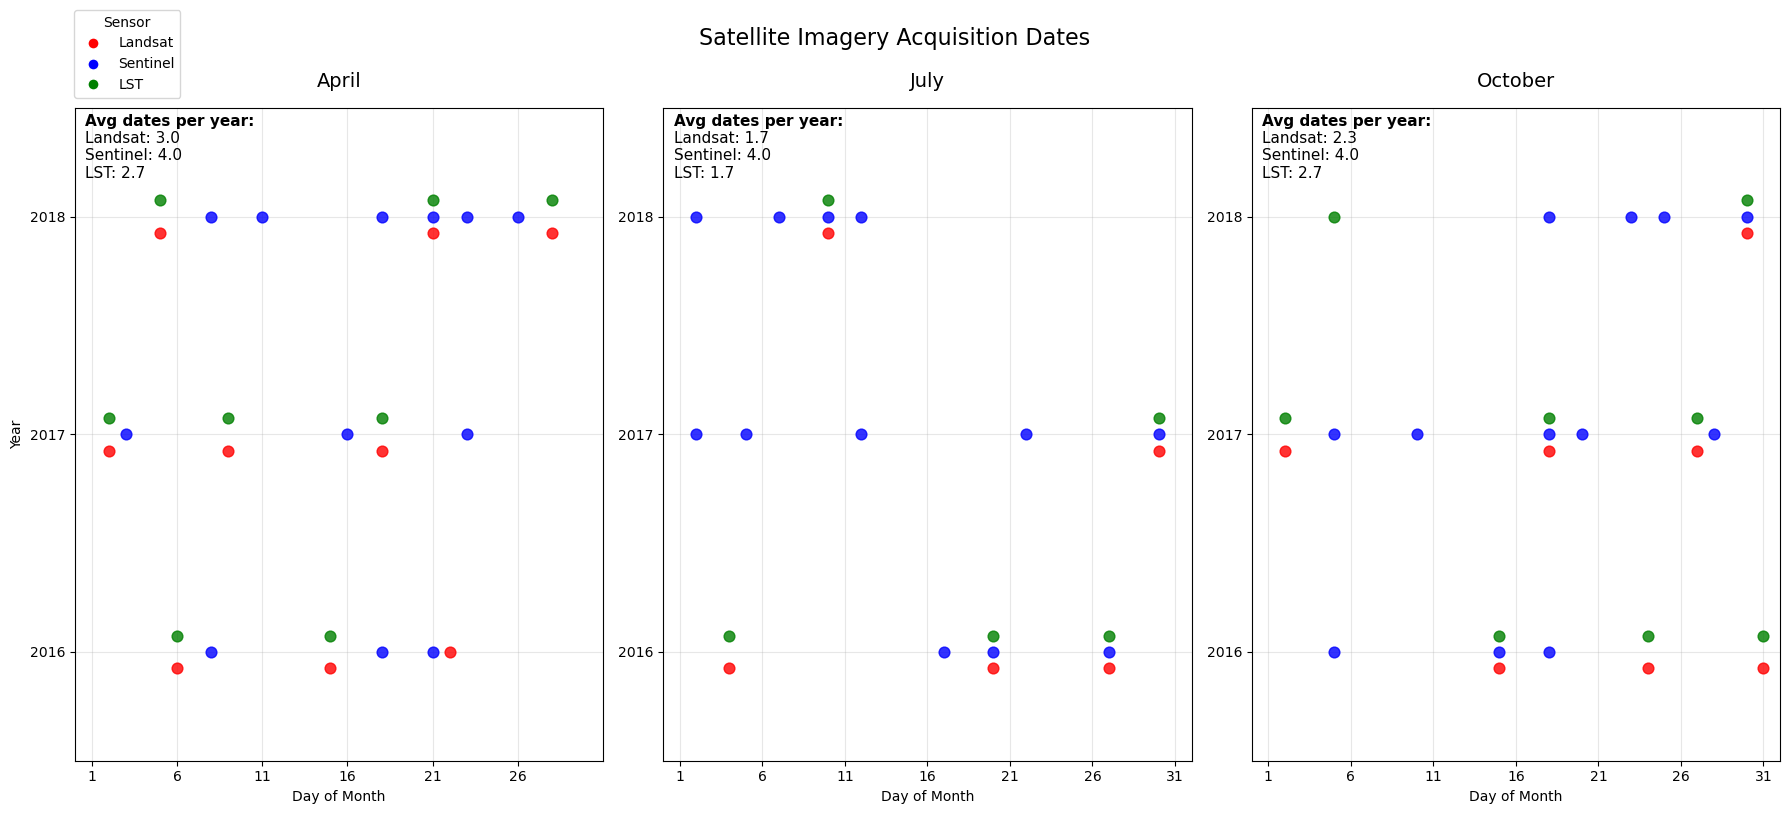

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Satellite Imagery Acquisition Dates', fontsize=16, y=0.99)

# Assuming you have these variables defined:
# months = [1, 2, 3] or whatever months you want to show
# years = list of years in your data
# month_names = ['January', 'February', 'March', etc.]

for j, month in enumerate(months):
    ax = axes[j]
    
    # Filter data for this month across all years
    month_mask = df['month'] == month
    month_data = df[month_mask]


    sensor_yearly_counts = month_data.groupby(['sensor', 'year']).size()

    sensor_averages = {}
    for sensor in month_data['sensor'].unique():
        sensor_data = sensor_yearly_counts[sensor] if sensor in sensor_yearly_counts.index.get_level_values(0) else pd.Series(dtype=int)
        sensor_avg = sensor_data.mean() if len(sensor_data) > 0 else 0
        sensor_averages[sensor] = f"{sensor_avg:.1f}"
    
    # Get the maximum days in this month across all years
    max_days = max([calendar.monthrange(year, month)[1] for year in years])
    
    # Plot acquisition dates as points, colored by satellite
    # Group by day and year to handle overlapping points
    for (day, year), group in month_data.groupby(['day', 'year']):
        sensors = group['sensor'].tolist()
        n_sensors = len(sensors)
        
        if n_sensors == 1:
            # Single point, no offset needed
            color = satellite_colors[sensors[0]]
            ax.scatter(day, year, color=color, s=60, alpha=0.8, zorder=5)
        else:
            # Multiple points, apply vertical offset
            offset_range = 0.15  # Total range for offsets
            offsets = np.linspace(-offset_range/2, offset_range/2, n_sensors)
            
            for i, (_, row) in enumerate(group.iterrows()):
                color = satellite_colors[row['sensor']]
                y_pos = year + offsets[i]
                ax.scatter(day, y_pos, color=color, s=60, alpha=0.8, zorder=5)
    
    # Customize subplot
    ax.set_xlim(0, max_days + 1)
    ax.set_ylim(min(years) - 0.5, max(years) + 0.5)
    ax.set_xlabel('Day of Month')
    ax.set_ylabel('Year' if j == 0 else '')  # Only show ylabel on first subplot
    
    # Set x-ticks for days
    ax.set_xticks(range(1, max_days + 1, 5))  # Show every 5th day
    
    # Set y-ticks for years
    ax.set_yticks(years)
    ax.set_yticklabels(years)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add title showing month name
    ax.set_title(f'{month_names[j]}', fontsize=14, pad=15)

    ax.text(0.02, 0.99, 'Avg dates per year:', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='top', horizontalalignment='left',
        fontweight='bold')
        
    ax.text(0.02, 0.965, f'Landsat: {sensor_averages['Landsat']}\nSentinel: {sensor_averages['Sentinel']}\nLST: {sensor_averages['LST']}', 
            transform=ax.transAxes, fontsize=11, 
            verticalalignment='top', horizontalalignment='left')

# Add legend for satellites (outside the plots)
handles = []
labels = []
for sensor, color in satellite_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8))
    labels.append(sensor)

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.04, 1.02), title='Sensor')

plt.tight_layout()
plt.show()

In [32]:
year = ['2017', '2021','2017', '2021','2017','2021']
model = ['MOD_17', 'MOD_17', 'MOD_21', 'MOD_21','NLCD','NLCD']
rmse = [12.40, 13.46,13.76, 12.73,18.8,20.5]

df = pd.DataFrame({'year':year,'model':model,'rmse':rmse})

pivot_df = df.pivot(index='model', columns='year', values='rmse')

pivot_df

year,2017,2021
model,,
MOD_17,12.40,13.46
MOD_21,13.76,12.73
NLCD,18.80,20.50


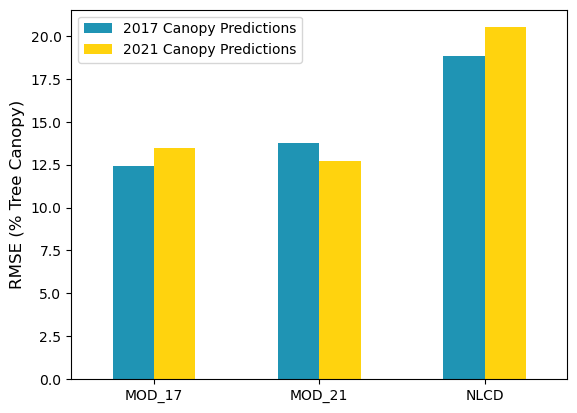

In [40]:
colors = {'2017': "#1f94b4", '2021': "#ffd30e"}

ax = pivot_df.plot(kind='bar',color=[colors[col] for col in pivot_df.columns])
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('RMSE (% Tree Canopy)', fontsize=12)
ax.legend(labels=['2017 Canopy Predictions', '2021 Canopy Predictions'])
plt.xticks(rotation=0)  # keep model names horizontal
plt.show()

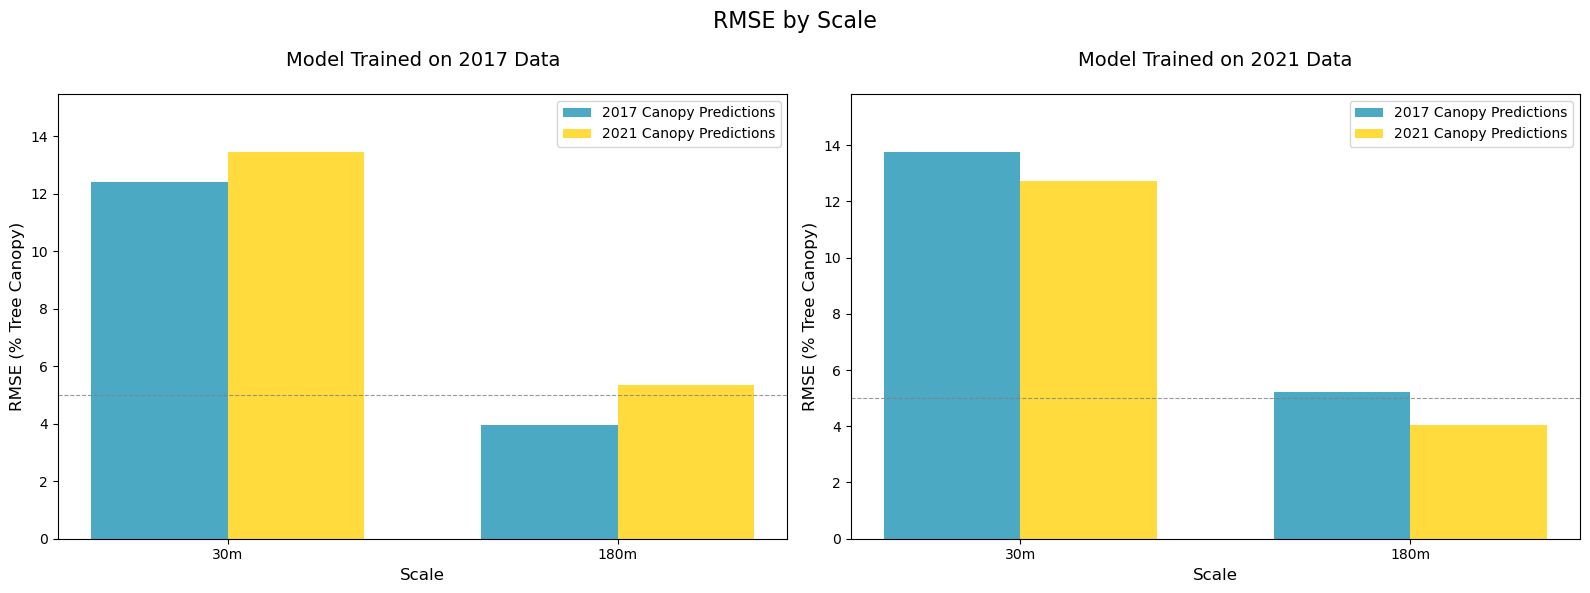

In [ ]:
year = ['2017', '2021', '2017', '2021']
scale = ['30m', '30m', '180m', '180m']
rmse = [12.40, 13.46, 3.97, 5.34]
df_2017model = pd.DataFrame({'year': year, 'scale': scale, 'rmse': rmse})

year = ['2017', '2021', '2017', '2021']
scale = ['30m', '30m', '180m', '180m']
rmse = [ 13.76, 12.73, 5.21, 4.03,]
df_2021model = pd.DataFrame({'year': year, 'scale': scale, 'rmse': rmse})


def plot_rmse_bars(ax, df, title):
    # Define colors for each year
    colors = {'2017': "#1f94b4", '2021': "#ffd30e"}  # Blue and orange
    
    # Get unique scales and years
    scales = df['scale'].unique()
    years = df['year'].unique()
    
    # Set width of bars and positions
    bar_width = 0.35
    x_pos = np.arange(len(scales))
    
    # Plot bars for each year
    for i, year_val in enumerate(years):
        year_data = df[df['year'] == year_val]
        rmse_values = []
        
        # Get RMSE values for each scale for this year
        for scale_val in scales:
            scale_data = year_data[year_data['scale'] == scale_val]
            if not scale_data.empty:
                rmse_values.append(scale_data['rmse'].iloc[0])
            else:
                rmse_values.append(0)  # If no data for this scale
        
        # Plot bars with offset
        bars = ax.bar(x_pos + i * bar_width, rmse_values, bar_width, 
                      label=year_val, color=colors[year_val], alpha=0.8)
        
    
    # Customize the subplot
    ax.set_xlabel('Scale', fontsize=12)
    ax.set_ylabel('RMSE (% Tree Canopy)', fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xticks(x_pos + bar_width / 2)
    ax.set_xticklabels(scales)
    ax.legend(labels=['2017 Canopy Predictions', '2021 Canopy Predictions'])
    ax.axhline(y=5,alpha=0.8,linewidth=.8,color='grey',linestyle='--')
    
    # Set y-axis to start from 0 for better comparison
    max_rmse = max(df['rmse'])
    ax.set_ylim(0, max_rmse * 1.15)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot both dataframes
plot_rmse_bars(axes[0], df_2017model, 'Model Trained on 2017 Data')
plot_rmse_bars(axes[1], df_2021model, 'Model Trained on 2021 Data')

# Add overall title
fig.suptitle('RMSE by Scale', fontsize=16, y=0.98)

plt.tight_layout()
plt.show()

In [ ]:
actual_gdf = ca.nta_actual
pred_gdf = ca.nta_change_gdf

bins = [(-5,0),(0, 2), (2, 4), (4, 6), (6, 8)]
titles = ['<0%','0–2%', '2–4%', '4–6%', '6–8%']

fig, axes = plt.subplots(1, len(bins), figsize=(14, 4), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten for easy indexing

for i, (low, high) in enumerate(bins):
    ax = axes[i]
    
    # Filter data in bin range
    mask = (actual_gdf['can_netchng_pct_20172021'] >= low) & (actual_gdf['can_netchng_pct_20172021'] < high)
    x = actual_gdf.loc[mask, 'can_netchng_pct_20172021']
    y = pred_gdf.loc[mask, 'predicted_change']
    
    # Compute R² for this subset
    if len(x) > 3:
        spr, _ = spearmanr(x, y)
    else:
        spr = None  # Not enough data for R²
    
    # Plot
    ax.scatter(x, y, alpha=0.7, edgecolor='k')
    ax.plot([-10, 20], [-10, 20], color='red', linestyle='--')  # AB line
    if spr is not None:
        ax.text(0.01, 0.98, f"Spearman's r = {spr:.3f}", 
            transform=ax.transAxes, fontsize=11, verticalalignment='top')
    else:
        ax.text(0.01, 0.98, f"Spearman's r undefined", 
            transform=ax.transAxes, fontsize=11, verticalalignment='top')
    
    ax.set_title(f'Actual Change: {titles[i]}')
    ax.grid(False)
    ax.set_xlim(-10, 20)
    ax.set_ylim(-10, 20)

# Set common labels
fig.text(0.5, 0.04, 'Actual Change in % Tree Canopy', ha='center', fontsize=11)
fig.text(0.04, 0.5, 'Predicted Change in % Tree Canopy', va='center', rotation='vertical', fontsize=11)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [5]:
### plot number of valid spectral observations

site = 'nyc17v6'

landsat = xr.open_dataarray(root / 'data' / site / 'landsat_aligned_bands.nc')
landsat = landsat.drop_sel(band=['tir1','tir2'])
landsat = landsat.sel(time=landsat.time.dt.month.isin([4, 7, 10]),band='red')
sentinel = xr.open_dataarray(root / 'data' / site / 'sentinel_aligned_bands.nc')
sentinel = sentinel.sel(time=sentinel.time.dt.month.isin([4, 7, 10]),band='red')

l_count = xr.where(xr.ufuncs.isfinite(landsat), 1, 0).sum(dim="time")
s_count = xr.where(xr.ufuncs.isfinite(sentinel), 1, 0).sum(dim="time")

ls_count = l_count + s_count

# ls_count.plot.imshow(levels=np.arange(0,51,10))
# plt.title('')
# plt.axis('off')


In [6]:
### plot number of valid lst observations

site = 'nyc17v6'
dates = [2016, 2017, 2018]

# site = 'nyc21v6'
# dates = [2020, 2021, 2022]

def open_lst(date):
    lst = xr.open_dataarray(root / 'data' / site / f'lst_data_{date}.nc')
    lst = lst.sel(time= lst.time.dt.month.isin([4, 7, 10]))
    return lst.isel(band=0)

lst1 = open_lst(dates[0])
lst2 = open_lst(dates[1])
lst3 = open_lst(dates[2])

lst = xr.concat([lst1,lst2,lst3],dim='time')

l_count = xr.where(xr.ufuncs.isfinite(lst), 1, 0).sum(dim="time")

# l_count.plot.imshow(levels=np.arange(0,31,5))
# plt.title('')
# plt.axis('off')

In [7]:
total_obs = ls_count + l_count

In [8]:
total_obs = total_obs.rio.write_crs(26918).rio.set_spatial_dims(x_dim="x",y_dim="y").rio.write_coordinate_system()

In [ ]:
resid17 = cp.prediction_raster - cp.lidar_raster

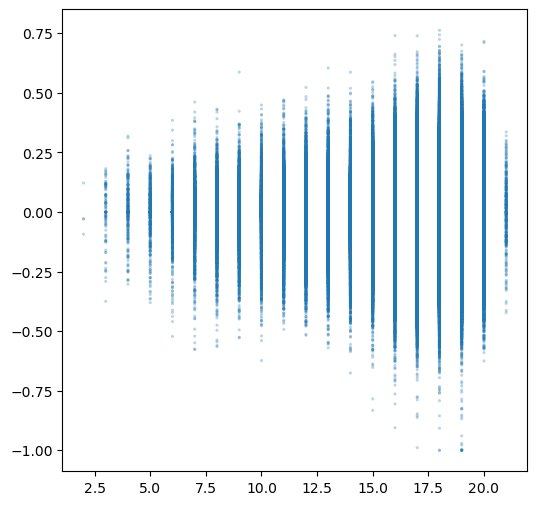

In [18]:
obs_1d = l_count.values.ravel()
resid17_1d = resid17.values.ravel()


plt.figure(figsize=(6,6))
plt.scatter(obs_1d, resid17_1d, alpha=0.3, s=5, edgecolor='none')

In [10]:
bound = gpd.read_file(root / 'output' / 'gpkg' / 'nta_for_nyc17v6_from_2017_model_b.gpkg')

bound.columns

Index(['can_2017_pct', 'can_2021_pct', 'predicted_tree_canopy_percent_cover',
       'predicted_canopy_binned', 'difference', 'geometry'],
      dtype='object')

In [11]:


mean_vals_list = []

for _, row in bound.iterrows():
    geom = [mapping(row.geometry)]

    # Create a mask for pixels inside the polygon
    mask = geometry_mask(geom,
                        transform=total_obs.rio.transform(),
                        invert=True,
                        out_shape=(total_obs.shape[-2], total_obs.shape[-1]))

    # Extract canopy values within the polygon
    vals = np.where(mask, total_obs.values, np.nan)

    mean_val = np.nanmean(vals)
   
    mean_vals_list.append(mean_val)


bound[f"avg_valid_obs"] = mean_vals_list

 # # Calculate area covered by canopy (as percent * pixel area)
    # canopy_area_m2 = np.nansum(canopy_vals * 900)

    # # Total area of polygon in m²
    # polygon_area_m2 = row.geometry.area

    # # Percent of polygon covered by canopy
    # percent_cover = (canopy_area_m2 / polygon_area_m2) * 100

<Axes: xlabel='avg_valid_obs', ylabel='abs_resid'>

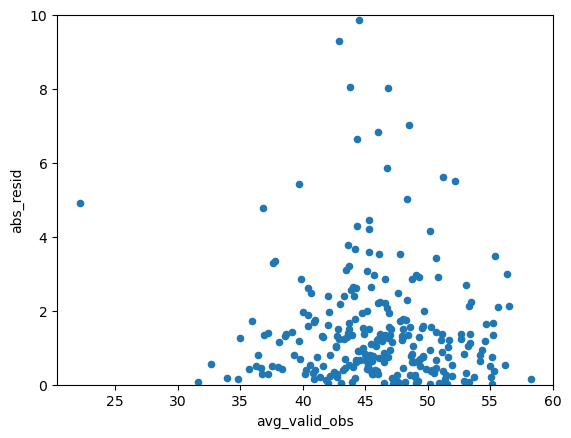

In [ ]:
bound['abs_resid'] = np.abs(bound['difference'])  # absolute value of residuals

bound.plot(x='avg_valid_obs',y='abs_resid',kind='scatter',ylim=(0,10))  # r = -0.25